In [26]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [27]:
num_epochs = 500
batch_size = 1
learning_rate = 0.001

input_size = 222
sequence_length = 4
hidden_size = 128
num_layers = 2

In [28]:
initialize=True

In [29]:
df = pd.read_csv('../data/united_oats.csv', index_col=0).fillna(0)
y = df['Oat_Yield']
X = df.drop(columns=['Oat_Yield'], axis=1)

In [30]:
y = pd.DataFrame(y)
def convert_corn_yield(row):
    idx = row.name
    year = int(idx[:4])
    row['Oat_Yield'] = row['Oat_Yield'] + (1950-year)*0.35535245
    return row  

In [31]:
y = y.apply(convert_corn_yield, axis=1)
y = y['Oat_Yield']

In [32]:
class MyDataset(Dataset):
 
  def __init__(self,X,y):
    self.x_train=torch.tensor(X,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

In [34]:
train_data=MyDataset(X_train.to_numpy(), y_train.to_numpy())
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=False)

test_data=MyDataset(X_test.to_numpy(), y_test.to_numpy())
train_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [35]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

In [36]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        if initialize:
            h0 = torch.zeros(num_layers, x.size(0), hidden_size)
            c0 = torch.zeros(num_layers, x.size(0), hidden_size)
            x, _ = self.lstm(x,(h0,c0))
        else:
            x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [37]:
model = LSTM(input_size, hidden_size, num_layers)
weather_test = X_test.reshape(-1, sequence_length, input_size)
weather_train = X_train.reshape(-1, sequence_length, input_size)
print(weather_test.shape)
print(weather_train.shape)

torch.Size([241, 4, 222])
torch.Size([723, 4, 222])


In [38]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
n_total_steps = len(train_loader)
train_losses = []
test_losses = []
min_test_loss = 9999999
for epoch in range(num_epochs):
    for i, (weather, labels) in enumerate(train_loader):  
        weather = weather.reshape(-1, sequence_length, input_size)
        
        # Forward pass
        outputs = model(weather)
        loss = criterion(outputs.reshape(-1), labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         if (i+1) % 100 == 0:
#             print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    if (epoch + 1) % 1 == 0:
        with torch.no_grad():
            outputs = model(weather_train)
            loss_train = criterion(outputs.reshape(-1), y_train)
            outputs = model(weather_test)
            loss_test = criterion(outputs.reshape(-1), y_test)
            train_losses.append(loss_train)
            test_losses.append(loss_test)
            if loss_test < min_test_loss:
                torch.save(model.state_dict(), "best-oat-500")
            print("Epoch: ", epoch + 1, " Train loss: ", loss_train.item(), "Test loss:", loss_test.item())

Epoch:  1  Train loss:  358.6776123046875 Test loss: 301.0109558105469
Epoch:  2  Train loss:  255.56472778320312 Test loss: 219.42071533203125
Epoch:  3  Train loss:  248.07315063476562 Test loss: 216.44651794433594
Epoch:  4  Train loss:  247.26193237304688 Test loss: 219.22959899902344
Epoch:  5  Train loss:  245.10487365722656 Test loss: 217.4320831298828
Epoch:  6  Train loss:  243.53990173339844 Test loss: 207.0076446533203
Epoch:  7  Train loss:  238.8526611328125 Test loss: 196.8815460205078
Epoch:  8  Train loss:  232.09494018554688 Test loss: 186.05726623535156
Epoch:  9  Train loss:  228.0039825439453 Test loss: 185.52894592285156
Epoch:  10  Train loss:  229.6859893798828 Test loss: 177.54307556152344
Epoch:  11  Train loss:  225.8614044189453 Test loss: 166.45692443847656
Epoch:  12  Train loss:  225.34173583984375 Test loss: 165.8227081298828
Epoch:  13  Train loss:  217.1034698486328 Test loss: 153.7830810546875
Epoch:  14  Train loss:  232.25518798828125 Test loss: 143.

Epoch:  114  Train loss:  234.3460693359375 Test loss: 30.115949630737305
Epoch:  115  Train loss:  212.02024841308594 Test loss: 25.544160842895508
Epoch:  116  Train loss:  221.58596801757812 Test loss: 20.81476593017578
Epoch:  117  Train loss:  222.0790557861328 Test loss: 24.057945251464844
Epoch:  118  Train loss:  229.7567901611328 Test loss: 22.295801162719727
Epoch:  119  Train loss:  225.1342010498047 Test loss: 21.814367294311523
Epoch:  120  Train loss:  226.6363525390625 Test loss: 20.246049880981445
Epoch:  121  Train loss:  246.7110137939453 Test loss: 25.415922164916992
Epoch:  122  Train loss:  233.35617065429688 Test loss: 34.18849563598633
Epoch:  123  Train loss:  235.39991760253906 Test loss: 28.38979148864746
Epoch:  124  Train loss:  231.9698944091797 Test loss: 23.580020904541016
Epoch:  125  Train loss:  242.1441650390625 Test loss: 47.8863410949707
Epoch:  126  Train loss:  229.38775634765625 Test loss: 45.03761291503906
Epoch:  127  Train loss:  214.440734863

Epoch:  225  Train loss:  235.04510498046875 Test loss: 21.966882705688477
Epoch:  226  Train loss:  233.7241973876953 Test loss: 14.649008750915527
Epoch:  227  Train loss:  222.93777465820312 Test loss: 13.875218391418457
Epoch:  228  Train loss:  215.23683166503906 Test loss: 24.19039535522461
Epoch:  229  Train loss:  243.03900146484375 Test loss: 19.112192153930664
Epoch:  230  Train loss:  250.3222198486328 Test loss: 24.91106605529785
Epoch:  231  Train loss:  234.51919555664062 Test loss: 15.805792808532715
Epoch:  232  Train loss:  236.21957397460938 Test loss: 14.85267162322998
Epoch:  233  Train loss:  240.1848602294922 Test loss: 20.197450637817383
Epoch:  234  Train loss:  225.39785766601562 Test loss: 22.88164520263672
Epoch:  235  Train loss:  225.03163146972656 Test loss: 16.774507522583008
Epoch:  236  Train loss:  232.6001434326172 Test loss: 21.22548484802246
Epoch:  237  Train loss:  226.16270446777344 Test loss: 15.942949295043945
Epoch:  238  Train loss:  226.3560

Epoch:  336  Train loss:  220.98744201660156 Test loss: 9.975325584411621
Epoch:  337  Train loss:  212.56614685058594 Test loss: 15.928666114807129
Epoch:  338  Train loss:  220.97509765625 Test loss: 20.729711532592773
Epoch:  339  Train loss:  238.4417724609375 Test loss: 13.180339813232422
Epoch:  340  Train loss:  214.89089965820312 Test loss: 13.854479789733887
Epoch:  341  Train loss:  226.69143676757812 Test loss: 16.314359664916992
Epoch:  342  Train loss:  222.45176696777344 Test loss: 9.927295684814453
Epoch:  343  Train loss:  232.2083282470703 Test loss: 12.092604637145996
Epoch:  344  Train loss:  236.24319458007812 Test loss: 11.818892478942871
Epoch:  345  Train loss:  226.07875061035156 Test loss: 14.952387809753418
Epoch:  346  Train loss:  229.71002197265625 Test loss: 14.02330207824707
Epoch:  347  Train loss:  228.16407775878906 Test loss: 30.357202529907227
Epoch:  348  Train loss:  227.1522674560547 Test loss: 19.169910430908203
Epoch:  349  Train loss:  211.4423

Epoch:  447  Train loss:  238.37498474121094 Test loss: 8.860273361206055
Epoch:  448  Train loss:  232.2904510498047 Test loss: 10.584962844848633
Epoch:  449  Train loss:  227.661376953125 Test loss: 12.183801651000977
Epoch:  450  Train loss:  242.36416625976562 Test loss: 10.45885181427002
Epoch:  451  Train loss:  243.3101806640625 Test loss: 9.79781723022461
Epoch:  452  Train loss:  240.94644165039062 Test loss: 10.703923225402832
Epoch:  453  Train loss:  237.01368713378906 Test loss: 9.253687858581543
Epoch:  454  Train loss:  237.84210205078125 Test loss: 8.161764144897461
Epoch:  455  Train loss:  233.00567626953125 Test loss: 18.167394638061523
Epoch:  456  Train loss:  230.87701416015625 Test loss: 11.120223999023438
Epoch:  457  Train loss:  225.8827362060547 Test loss: 9.987116813659668
Epoch:  458  Train loss:  234.338623046875 Test loss: 12.10151481628418
Epoch:  459  Train loss:  230.02667236328125 Test loss: 17.017852783203125
Epoch:  460  Train loss:  232.8151550292

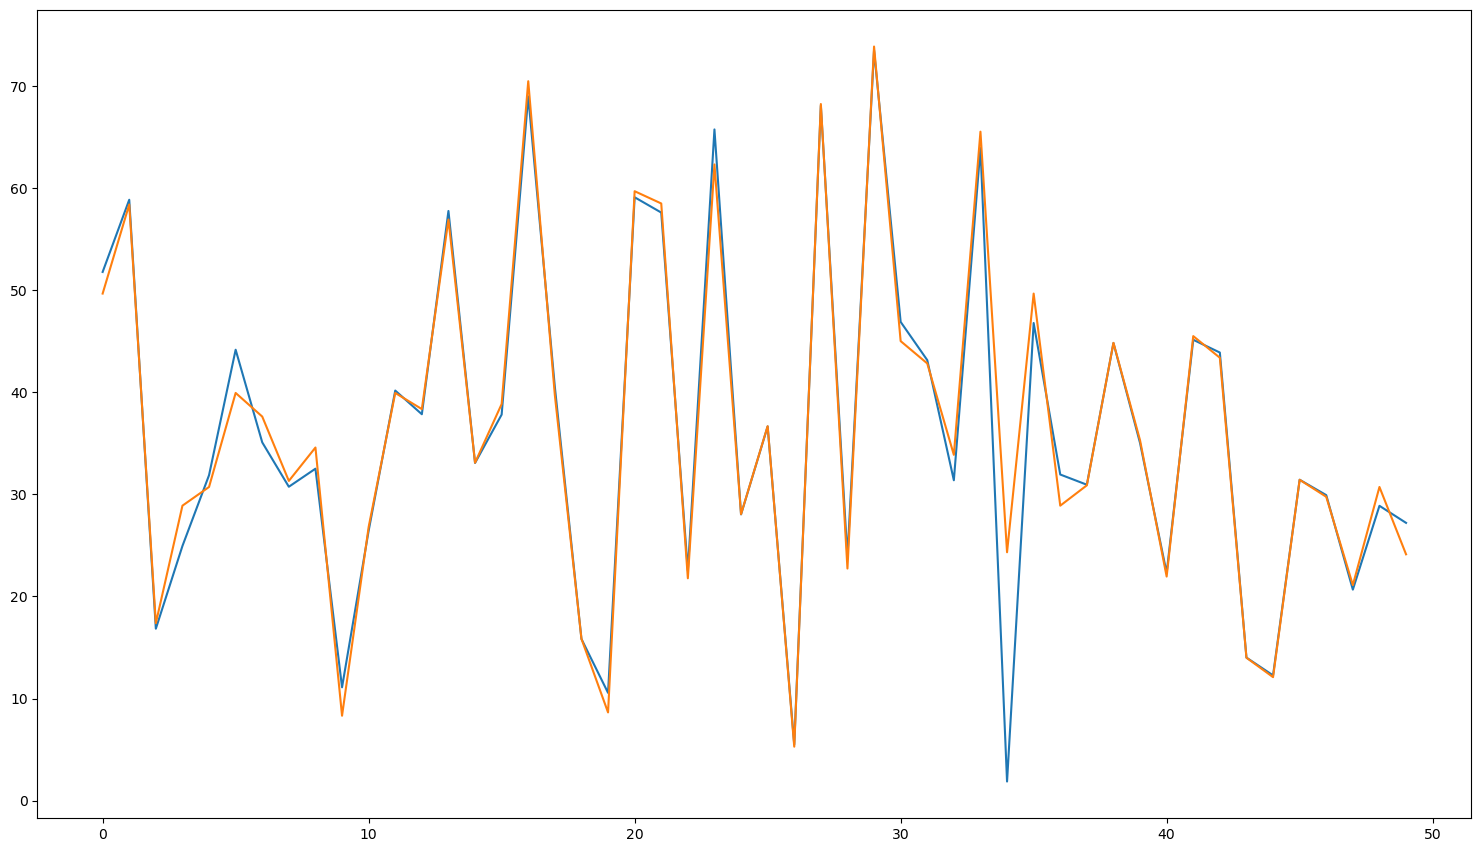

In [39]:
plt.plot(y_test[:50])
plt.plot(outputs[:50].detach())
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [40]:
from utils import get_data_pred

model.load_state_dict(torch.load("best-oat"))
out = get_data_pred('ACAvNTuEuFWcmwms', model, adjust=True)
out

tensor([[136.8534],
        [162.2755],
        [145.5975],
        [141.3932],
        [169.2242],
        [142.7644],
        [153.7741],
        [148.5941],
        [156.6452],
        [184.8379],
        [166.6174],
        [181.6385],
        [160.4877],
        [155.4698],
        [164.0909],
        [159.0375],
        [185.9217]])

<AxesSubplot:>

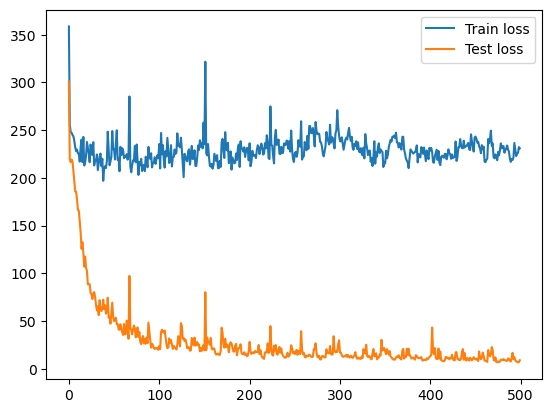

In [41]:
res = pd.DataFrame(data=np.asarray([train_losses, test_losses])).transpose()
res.columns = ['Train loss','Test loss']
res.plot()

### Load and evaluate the model

In [13]:
from utils import get_data_pred

model.load_state_dict(torch.load("lstm-adjusted-500"))
out = get_data_pred('ACAvNTuEuFWcmwms', model, adjust=True, crop='corn')
out

(tensor([[ 75.3805],
         [ 75.4429],
         [129.0984],
         [139.2952],
         [128.8876],
         [133.1449],
         [144.2295],
         [164.3298],
         [129.8442],
         [151.6084],
         [140.4799],
         [149.0764],
         [149.4333],
         [154.5029],
         [150.9960],
         [107.0173],
         [137.2893]]),
 2006,
 2022)

In [222]:
# outputs # of the model we trained without the adjustments

tensor([[100.2934],
        [ 96.1967],
        [ 95.1817],
        [112.0884],
        [ 98.1280],
        [ 88.9596],
        [156.1279],
        [137.4307],
        [ 74.4149],
        [108.9806],
        [119.3128],
        [126.0991],
        [127.9114],
        [104.2989],
        [106.2627],
        [154.4127],
        [ 77.3407]], grad_fn=<AddmmBackward0>)

In [16]:
out # oof the model we trained with the adjustments

tensor([[114.4748],
        [ 63.8450],
        [124.6391],
        [138.7735],
        [141.8226],
        [141.1663],
        [148.0757],
        [131.5047],
        [132.3883],
        [155.8086],
        [149.0855],
        [144.8992],
        [136.4871],
        [154.3260],
        [161.6747],
        [110.9454],
        [144.0197]])

In [ ]:
### Load and evaluate the model

from utils import get_data_pred

model.load_state_dict(torch.load("lstm-adjusted-500"))
out = get_data_pred('ACAvNTuEuFWcmwms', model, adjust=True, crop='corn')
out

# outputs # of the model we trained without the adjustments

out # oof the model we trained with the adjustments